# **Forecasting Project**


## **Introduction**

### **Goal**
The goal of this project is to develop a predictive model to forecast the number of taxi orders for the upcoming hour. This model will assist Sweet Lift, a taxi company, in attracting more drivers during peak hours and optimizing operational efficiency. The target is to achieve a root mean square error (RMSE) of 48 or less on the test set.

### **Steps**

1. **Data Acquisition and Resampling:**
   - Download the dataset from the provided file path.
   - Resample the data to aggregate it on an hourly basis.

2. **Data Analysis:**
   - Perform a comprehensive analysis of the resampled data to identify patterns and trends.

3. **Model Training and Evaluation:**
   - Train various models with different hyperparameters to determine the most effective forecasting approach.
   - Ensure the test sample represents 10% of the original dataset.
   - Evaluate the model's performance using the test sample, ensuring the RMSE does not exceed 48.

### **Data Description**
The dataset includes historical taxi order data with the number of orders recorded in the `num_orders` column. This data will be utilized for resampling, analysis, and model training to predict future taxi order volumes.


## **Data Loadment and Exploratory**

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.1 MB/s eta 0:00:00


In [2]:
# Import necessary library

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

### **Data Loadment**

In [3]:
# Data Loadment

path = '/content/taxi.csv'
df = pd.read_csv(path, index_col=[0], parse_dates=[0])
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# Data shape

df.shape

(26496, 1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
# missing value checking

df.isnull().sum()

num_orders    0
dtype: int64

In [7]:
# duplicated data checking

df.duplicated().sum()

26415

**Insight**

1. Data provided contains 26496 rows and 1 column of number of order for each 10 minutes of time interval.
2. There are no missing value has been found.
3. There are no duplicated value has been found.

### **Data Exploratory**

In [8]:
df = df.resample('1H').sum()

In [9]:
df_eda = df.copy()
df_eda.tail(5)

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


<Axes: xlabel='datetime'>

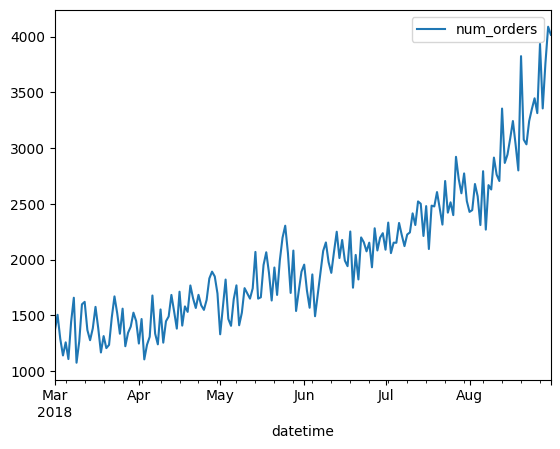

In [10]:
df_eda_daily = df_eda.resample('1D').sum()
df_eda_daily.plot()

<Axes: xlabel='datetime'>

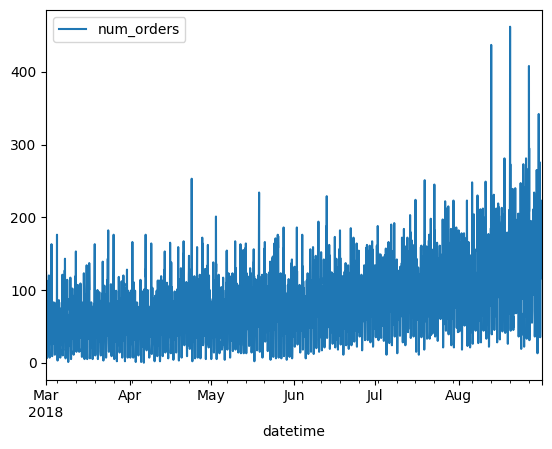

In [11]:
df_eda_hourly = df_eda.resample('1H').sum()
df_eda_hourly.plot()

<Axes: xlabel='datetime'>

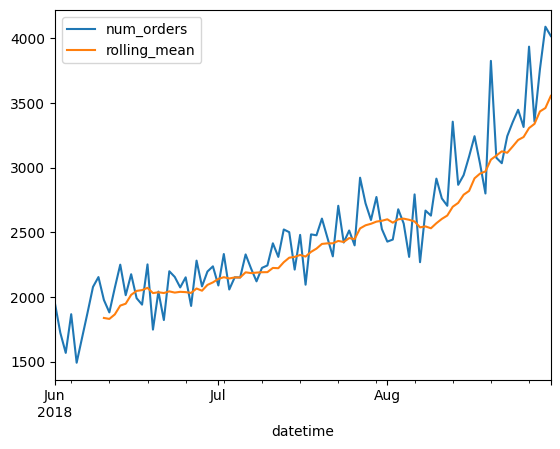

In [12]:
df_eda.sort_index(inplace=True)
df_eda = df_eda['2018-06':'2018-08'].resample('1D').sum()
df_eda['rolling_mean'] = df_eda.rolling(10).mean()
df_eda.plot()

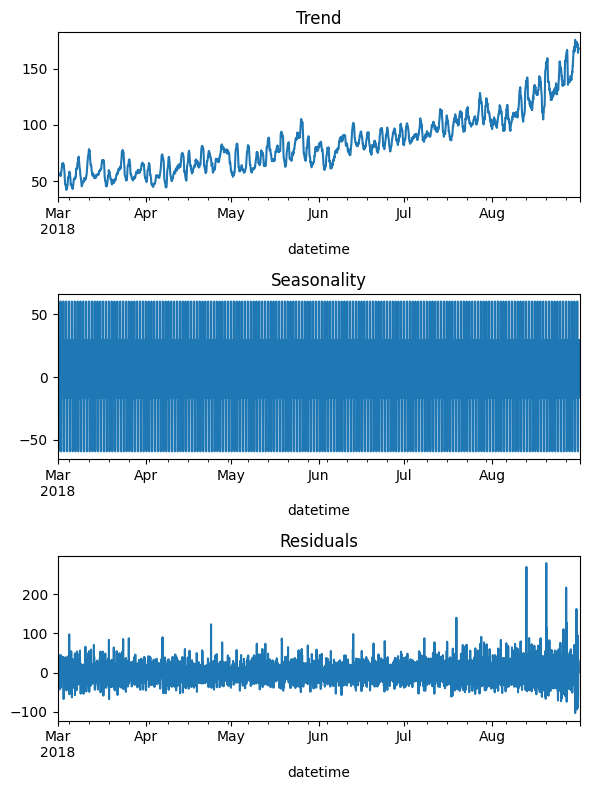

In [13]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

**Insigth**

The data shows consistency of increase order started from March to August 2018.

## **Machine Learning Development**

Create a function to add time-based features and lagged values to a DataFrame for use in time series forecasting.

In [14]:
def make_features(df, max_lag=4, rolling_mean_size=10):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek_num'] = df.index.dayofweek
    df['hour'] = df.index.hour

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [15]:
make_features(df)
df = df.dropna()
print(df.shape)

(4406, 10)


In [16]:
df.head(2)

,num_orders,month,day,dayofweek_num,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,52.5
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,46.5


In [17]:
# Splitting the data into train, test, and valid dataset

train_valid, test = train_test_split(df, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

In [18]:
print(train.index.min(), train.index.max())
print(train.shape)
print(test.index.min(), test.index.max())
print(test.shape)
print(valid.index.min(), valid.index.max())
print(valid.shape)

2018-03-01 10:00:00 2018-07-28 01:00:00
(3568, 10)
2018-08-13 15:00:00 2018-08-31 23:00:00
(441, 10)
2018-07-28 02:00:00 2018-08-13 14:00:00
(397, 10)


In [19]:
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']
X_valid = valid.drop(['num_orders'], axis=1)
y_valid = valid['num_orders']

In [20]:
X_train.shape, y_train.shape

((3568, 9), (3568,))

In [21]:
X_test.shape, y_test.shape

((441, 9), (441,))

In [22]:
X_valid.shape, y_valid.shape

((397, 9), (397,))

In [23]:
def rmse(true, pred):
    return mean_squared_error(true, pred)**0.5

In [24]:
print('Mean value:', test['num_orders'].mean())
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]

print('RMSE prev:', rmse(test['num_orders'], pred_previous['num_orders']))
pred_mean = np.ones(test['num_orders'].shape) * train['num_orders'].mean()
print('RMSE mean:', rmse(test['num_orders'], pred_mean))

Mean value: 139.64172335600907
RMSE prev: 58.82268986995932
RMSE mean: 87.35030729608127


### **Linear Regression**

In [25]:
%%time

# Linear Regression Model

lr = LinearRegression()
lr.fit(X_train, y_train)

pred_train = lr.predict(X_train)
pred_valid = lr.predict(X_valid)

print('RMSE train:', rmse(y_train, pred_train).round(3))
print('RMSE valid:', rmse(y_valid, pred_valid).round(3))
print('')

RMSE train: 29.189
RMSE valid: 40.539

CPU times: user 24.4 ms, sys: 21.3 ms, total: 45.7 ms
Wall time: 65.1 ms


### **Random Forest Regressor**

In [26]:
%%time

# Random Forest Regressor Model

depth = [2, 4, 6, 8, None]

for max_depth in depth:
    rf = RandomForestRegressor(n_estimators=500, max_depth=max_depth)
    rf.fit(X_train, y_train)

    pred_train = rf.predict(X_train)
    pred_valid = rf.predict(X_valid)

    print('Max depth:', max_depth)
    print('RMSE train:', rmse(y_train, pred_train).round(3))
    print('RMSE valid:', rmse(y_valid, pred_valid).round(3))
    print('')

Max depth: 2
RMSE train: 28.615
RMSE valid: 47.885

Max depth: 4
RMSE train: 24.785
RMSE valid: 41.13

Max depth: 6
RMSE train: 21.187
RMSE valid: 35.315

Max depth: 8
RMSE train: 17.595
RMSE valid: 33.16

Max depth: None
RMSE train: 7.79
RMSE valid: 31.793

CPU times: user 29.2 s, sys: 269 ms, total: 29.5 s
Wall time: 39.3 s


### **Light GBM**

In [27]:
%%time

# Light GBM Model

lg = LGBMRegressor(learning_rate=0.02, num_iterations=10, objective='rmse')
lg.fit(X_train, y_train, eval_set=(X_valid, y_valid))

pred_train = lg.predict(X_train)
pred_valid = lg.predict(X_valid)

print('')
print('RMSE train:', rmse(y_train, pred_train).round(3))
print('RMSE valid:', rmse(y_valid, pred_valid).round(3))
print('')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 3568, number of used features: 9
[LightGBM] [Info] Start training from score 74.853980

RMSE train: 32.195
RMSE valid: 52.586

CPU times: user 54.2 ms, sys: 2.91 ms, total: 57.1 ms
Wall time: 88.4 ms


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


### **Cat Boost**

In [28]:
%%time

# Cat Boost Model

cb = CatBoostRegressor(iterations=10, learning_rate=0.02, metric_period=100, loss_function='RMSE')
cb.fit(X_train, y_train, eval_set=(X_valid, y_valid))

pred_train = cb.predict(X_train)
pred_valid = cb.predict(X_valid)

print('')
print('RMSE train:', rmse(y_train, pred_train).round(3))
print('RMSE valid:', rmse(y_valid, pred_valid).round(3))
print('')

0:	learn: 35.7441940	test: 57.4799234	best: 57.4799234 (0)	total: 48.5ms	remaining: 437ms
9:	learn: 33.1438520	test: 54.0831356	best: 54.0831356 (9)	total: 75.5ms	remaining: 0us

bestTest = 54.08313564
bestIteration = 9


RMSE train: 33.144
RMSE valid: 54.083

CPU times: user 62.5 ms, sys: 14.8 ms, total: 77.3 ms
Wall time: 154 ms


**Insight**

Based on the several machine learning model that has been experimented on train dataset. The result obtained are listed as below:

1. Linear Regression Model
- RMSE train: 29.189
- RMSE valid: 40.539

2. Random Forest Regressor Model
- Max depth: None
- RMSE train: 7.792
- RMSE valid: 31.76

3. Light GBM Model
- RMSE train: 32.195
- RMSE valid: 52.586

4. Cat Boost Model
- RMSE train: 33.144
- RMSE valid: 54.083

## **Testing Model on Test Dataset**

In [29]:
# Testing on test dataset

X_train_valid = train_valid.drop(['num_orders'], axis=1)
y_train_valid = train_valid['num_orders']

### **Linear Regression**

In [30]:
%%time

# Linear Regression Model

lr = LinearRegression()
lr.fit(X_train_valid, y_train_valid)

pred_train = lr.predict(X_train_valid)
print('RMSE train:', rmse(y_train_valid, pred_train).round(3))

pred_test = lr.predict(X_test)
print('RMSE test:', rmse(y_test, pred_test).round(3))

print('')

RMSE train: 30.489
RMSE test: 53.178

CPU times: user 22.9 ms, sys: 10.9 ms, total: 33.8 ms
Wall time: 28 ms


### **Random Forest**

In [31]:
%%time

# Random Forest Regressor

rf = RandomForestRegressor(n_estimators=500)
rf.fit(X_train_valid, y_train_valid)

pred_train = rf.predict(X_train_valid)
print('RMSE train:', rmse(y_train_valid, pred_train).round(3))

pred_test = rf.predict(X_test)
print('RMSE test:', rmse(y_test, pred_test).round(3))

print('')

RMSE train: 8.253
RMSE test: 45.946

CPU times: user 10.8 s, sys: 74.8 ms, total: 10.9 s
Wall time: 10.9 s


### **Light GBM**

In [32]:
%%time

# Light GBM Model

lg = LGBMRegressor(learning_rate=0.02, num_iterations=10, objective='rmse')
lg.fit(X_train_valid, y_train_valid)

pred_train = lg.predict(X_train_valid)
print('RMSE train:', rmse(y_train_valid, pred_train).round(3))

pred_test = lg.predict(X_test)
print('RMSE test:', rmse(y_test, pred_test).round(3))

print('')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 3965, number of used features: 9
[LightGBM] [Info] Start training from score 78.361665
RMSE train: 34.461
RMSE test: 77.177

CPU times: user 29.5 ms, sys: 2.93 ms, total: 32.4 ms
Wall time: 31.4 ms


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


### **Cat Boost**

In [33]:
%%time

# Cat Boost Model

cb = CatBoostRegressor(iterations=10, learning_rate=0.02, metric_period=100, loss_function='RMSE')
cb.fit(X_train_valid, y_train_valid)

pred_train = cb.predict(X_train_valid)
print('RMSE train:', rmse(y_train_valid, pred_train).round(3))

pred_test = cb.predict(X_test)
print('RMSE test:', rmse(y_test, pred_test).round(3))

print('')

0:	learn: 38.3032227	total: 2.67ms	remaining: 24ms
9:	learn: 35.4993743	total: 19.3ms	remaining: 0us
RMSE train: 35.499
RMSE test: 80.164

CPU times: user 55.2 ms, sys: 8.92 ms, total: 64.1 ms
Wall time: 66.2 ms


**Insight**

Based on the several machine learning model that has been experimented on test dataset. The result obtained are listed as below:

1. Linear Regression Model
- RMSE train: 30.489
- RMSE test: 53.178

2. Random Forest Regressor Model
- Max depth: None
- RMSE train: 8.239
- RMSE test: 46.198

3. Light GBM Model
- RMSE train: 34.461
- RMSE test: 77.177

4. Cat Boost Model
- RMSE train: 35.499
- RMSE test: 80.164

## **Conclusion**

The goal of this project is to formulate machine learning model to predict the order of the next hour that has the RMSE value less than 48.

Exploratory Data Analysis has been conducted and found that:
1. Data provided contains 26496 rows and 1 column of number of order for each 10 minutes of time interval.
2. There are no missing value has been found.
3. There are no duplicated value has been found.
4. The data shows consistency of increase order started from March to August 2018.

The development of machine learning model has been conducted with the 10% of dataset test and the results are as below:

Based on the several machine learning model that has been experimented on train dataset. The result obtained are listed as below:

1. Linear Regression Model
- RMSE train: 29.189
- RMSE valid: 40.539

2. Random Forest Regressor Model
- Max depth: None
- RMSE train: 7.792
- RMSE valid: 31.76

3. Light GBM Model
- RMSE train: 32.195
- RMSE valid: 52.586

4. Cat Boost Model
- RMSE train: 33.144
- RMSE valid: 54.083

Based on the several machine learning model that has been experimented on test dataset. The result obtained are listed as below:

1. Linear Regression Model
- RMSE train: 30.489
- RMSE test: 53.178

2. Random Forest Regressor Model
- Max depth: None
- RMSE train: 8.239
- RMSE test: 46.198

3. Light GBM Model
- RMSE train: 34.461
- RMSE test: 77.177

4. Cat Boost Model
- RMSE train: 35.499
- RMSE test: 80.164

Therefore, based on the machine learning performance on the test dataset, we can conclude that the best machine learning model that pass the specification of less than 48 on RMSE score is Randon Forest Regressor with n_estimators value of 500.